## **INSTALL DEPENDECIES AND DRIVE CONNECTION** 📚

---




In [ ]:
%matplotlib inline
import os, glob, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import shutil
import torch
from torchvision.utils import make_grid
from torchvision import transforms
import torchvision.transforms.functional as TF
from torch import nn, optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import DataLoader, Dataset
!pip install pytorch_lightning --quiet
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.2/721.2 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 728.8/728.8 kB 54.0 MB/s eta 0:00:00


In [ ]:
print(pl.__version__)

2.0.4


In [ ]:
from google.colab import drive
drive.mount('/content/drive/',force_remount=True)

Mounted at /content/drive/


In [ ]:
import os
os.chdir('/content/drive/MyDrive/Lightning_GAN_Style_Transfer/')
!ls

checkpoints				     dataset	     loss_plots
cyclegan-pytorch-lightning.ipynb	     epochs_plots    results
cyclegan_pytorch_lightningQUELLO-BONO.ipynb  epochs_plots_1


In [ ]:
# IDENTIFY CORRECT DEVICE
if torch.backends.mps.is_available():
    dev = "mps"
elif torch.cuda.is_available():
    dev = "cuda"
else:
    dev = "cpu"

device = torch.device(dev)
print(device)

cuda


In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.mps.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

## **DATASET** 🎨📲


---



In [ ]:
class ImageTransform:
    def __init__(self, img_size=256):
        self.transform = {
            'train': transforms.Compose([
                transforms.Resize((img_size, img_size)),
                transforms.RandomHorizontalFlip(),
                transforms.RandomVerticalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.5], std=[0.5])
            ]),
            'test': transforms.Compose([
                transforms.Resize((img_size, img_size)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.5], std=[0.5])
            ])}

    def __call__(self, img, phase='train'):
        img = self.transform[phase](img)

        return img

In [ ]:
# MODULE TO MANAGE DATA
class StyleTransferDataset(Dataset):
    def __init__(self, base_img_paths, style_img_paths,  transform, phase='train'):
        self.base_img_paths = base_img_paths
        self.style_img_paths = style_img_paths
        self.transform = transform
        self.phase = phase

    def __len__(self):
        return min([len(self.base_img_paths), len(self.style_img_paths)])

    def __getitem__(self, idx):
        base_img_path = self.base_img_paths[idx]
        style_img_path = self.style_img_paths[idx]
        base_img = Image.open(base_img_path)
        style_img = Image.open(style_img_path)

        base_img = self.transform(base_img, self.phase)
        style_img = self.transform(style_img, self.phase)

        return base_img, style_img

In [ ]:
# DATA MODULE TO PREPARE DATA
class StyleTransferDataModule(pl.LightningDataModule):
    def __init__(self, data_dir, transform, batch_size, phase='train', seed=0):
        super(StyleTransferDataModule, self).__init__()
        self.data_dir = data_dir
        self.transform = transform
        self.batch_size = batch_size
        self.phase = phase
        self.seed = seed

    def prepare_data(self):   # search for images in two different dirs
        self.base_img_paths = glob.glob(os.path.join(self.data_dir, 'landscape_resized_256', '*.jpg'))
        self.style_img_paths = glob.glob(os.path.join(self.data_dir, 'abstract_resized_256', '*.jpg'))

    def train_dataloader(self):
        random.seed()
        random.shuffle(self.base_img_paths)
        random.shuffle(self.style_img_paths)
        random.seed(self.seed)
        self.train_dataset = StyleTransferDataset(self.base_img_paths, self.style_img_paths, self.transform, self.phase)

        return DataLoader(self.train_dataset,
                          batch_size=self.batch_size,
                          shuffle=True,
                          pin_memory=True
                         )

In [ ]:
# SANITY CHECK
data_dir = '../Some_Datasets/' ## to modify
transform = ImageTransform(img_size=256)
batch_size = 8

data = StyleTransferDataModule(data_dir, transform, batch_size, phase='test')
data.prepare_data()

dataloader = data.train_dataloader()
base, style = next(iter(dataloader))

print('Input Shape {}, {}'.format(base.size(), style.size()))

Input Shape torch.Size([8, 3, 256, 256]), torch.Size([8, 3, 256, 256])


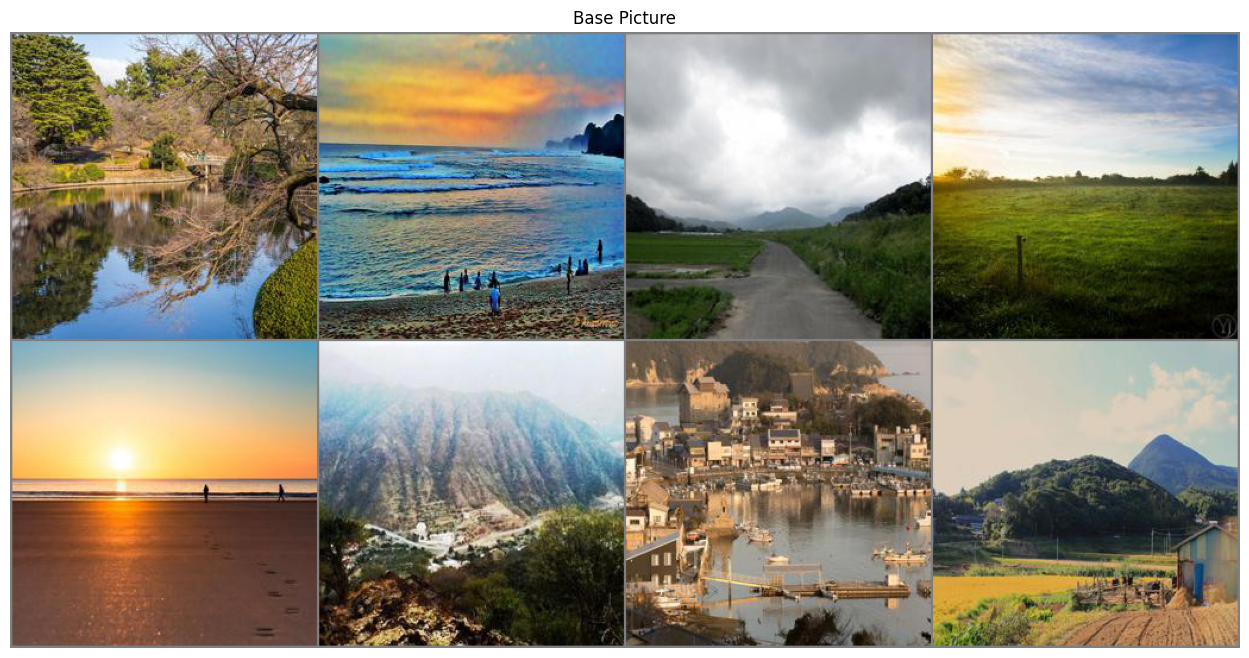

In [ ]:
# BASE IMG

temp = make_grid(base, nrow=4, padding=2).permute(1, 2, 0).detach().numpy()
temp = temp * 0.5 + 0.5
temp = temp * 255.0
temp = temp.astype(int)

fig = plt.figure(figsize=(18, 8), facecolor='w')
plt.imshow(temp)
plt.axis('off')
plt.title('Base Picture')
plt.show()

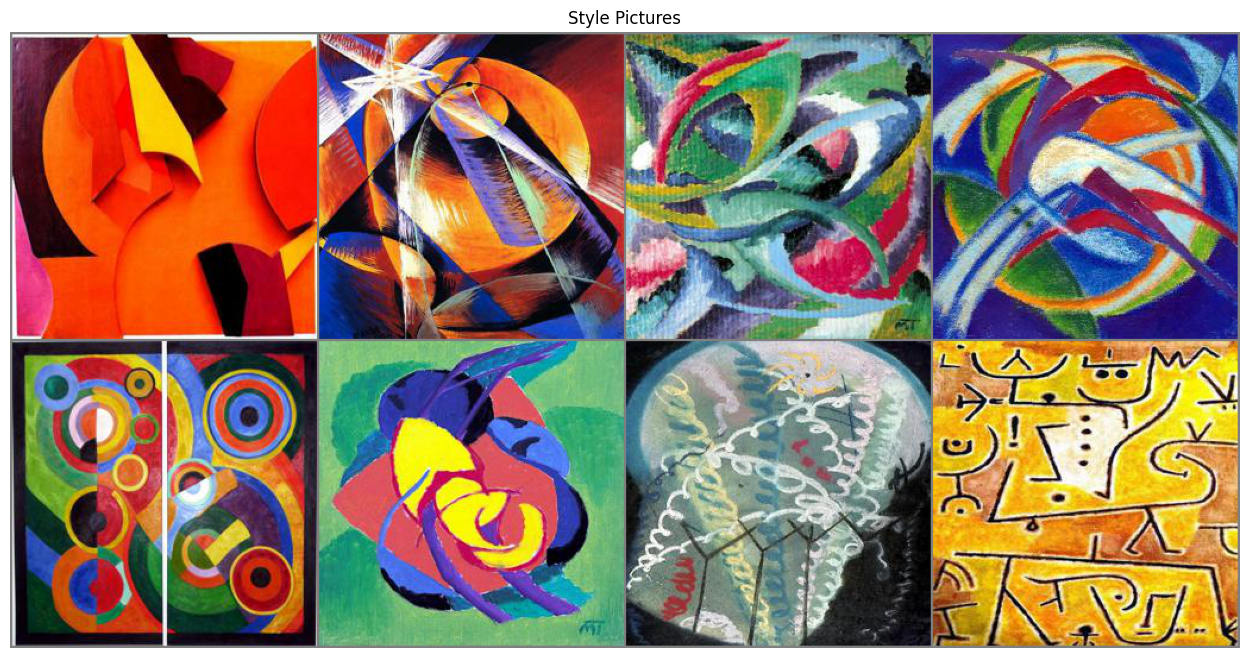

In [ ]:
# STYLE IMG

temp = make_grid(style, nrow=4, padding=2).permute(1, 2, 0).detach().numpy()
temp = temp * 0.5 + 0.5
temp = temp * 255.0
temp = temp.astype(int)

fig = plt.figure(figsize=(18, 8), facecolor='w')
plt.imshow(temp)
plt.axis('off')
plt.title('Style Pictures')
plt.show()


## **MODELS** ⚓
---

### **UP/DOWNSAMPLE** ⏫ ⏬

In [ ]:
class Upsample(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=4, stride=2, padding=1, dropout=True):
        super(Upsample, self).__init__()
        self.dropout = dropout
        self.block = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=nn.InstanceNorm2d),
            nn.InstanceNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        self.dropout_layer = nn.Dropout2d(0.5)

    def forward(self, x, shortcut=None):
        x = self.block(x)
        if self.dropout:
            x = self.dropout_layer(x)

        if shortcut is not None:
            x = torch.cat([x, shortcut], dim=1)

        return x


class Downsample(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=4, stride=2, padding=1, apply_instancenorm=True):
        super(Downsample, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=nn.InstanceNorm2d)
        self.norm = nn.InstanceNorm2d(out_channels)
        self.relu = nn.LeakyReLU(0.2, inplace=True)
        self.apply_norm = apply_instancenorm

    def forward(self, x):
        x = self.conv(x)
        if self.apply_norm:
            x = self.norm(x)
        x = self.relu(x)

        return x

### **GENERATOR** 🤥

---



In [ ]:
class Generator(nn.Module):
    def __init__(self, filter=64):
        super(Generator, self).__init__()
        self.downsamples = nn.ModuleList([
            Downsample(3, filter, kernel_size=4, apply_instancenorm=False),  # (b, filter, 128, 128)
            Downsample(filter, filter * 2),  # (b, filter * 2, 64, 64)
            Downsample(filter * 2, filter * 4),  # (b, filter * 4, 32, 32)
            Downsample(filter * 4, filter * 8),  # (b, filter * 8, 16, 16)
            Downsample(filter * 8, filter * 8), # (b, filter * 8, 8, 8)
            Downsample(filter * 8, filter * 8), # (b, filter * 8, 4, 4)
            Downsample(filter * 8, filter * 8), # (b, filter * 8, 2, 2)
        ])

        self.upsamples = nn.ModuleList([
            Upsample(filter * 8, filter * 8),
            Upsample(filter * 16, filter * 8),
            Upsample(filter * 16, filter * 8),
            Upsample(filter * 16, filter * 4, dropout=False),
            Upsample(filter * 8, filter * 2, dropout=False),
            Upsample(filter * 4, filter, dropout=False)
        ])

        self.last = nn.Sequential(
            nn.ConvTranspose2d(filter * 2, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        skips = []
        for l in self.downsamples:
            x = l(x)
            skips.append(x)

        skips = reversed(skips[:-1])
        for l, s in zip(self.upsamples, skips):
            x = l(x, s)

        out = self.last(x)

        return out

### **DISCRIMINATOR**  🧐



In [ ]:
class Discriminator(nn.Module):
    def __init__(self, filter=64):
        super(Discriminator, self).__init__()

        self.block = nn.Sequential(
            Downsample(3, filter, kernel_size=4, stride=2, apply_instancenorm=False),
            Downsample(filter, filter * 2, kernel_size=4, stride=2),
            Downsample(filter * 2, filter * 4, kernel_size=4, stride=2),
            Downsample(filter * 4, filter * 8, kernel_size=4, stride=1),
        )

        self.last = nn.Conv2d(filter * 8, 1, kernel_size=4, stride=1, padding=1)

    def forward(self, x):
        x = self.block(x)
        x = self.last(x)

        return x

In [ ]:
# Sanity Check
net = Generator()

out = net(base)
print(out.size())

torch.Size([8, 3, 256, 256])


In [ ]:
# Sanity Check
net = Discriminator()

out = net(base)
print(out.size())

torch.Size([8, 1, 30, 30])


## ⚡⚡⚡ **LIGHTNING MODULE** ⚡⚡⚡

In [ ]:
class LightnigGAN(pl.LightningModule):
    def __init__(self, G_basestyle, G_stylebase, D_base, D_style, lr, transform, reconstr_w=10, id_w=2):
        super(LightnigGAN, self).__init__()
        self.automatic_optimization = False
        self.G_basestyle = G_basestyle
        self.G_stylebase = G_stylebase
        self.D_base = D_base
        self.D_style = D_style
        self.lr = lr
        self.transform = transform
        self.reconstr_w = reconstr_w
        self.id_w = id_w

        self.mae = nn.L1Loss()
        self.generator_loss = nn.MSELoss()
        self.discriminator_loss = nn.MSELoss()

        self.losses = []
        self.G_mean_losses = []
        self.D_mean_losses = []
        self.validity = []
        self.reconstr = []
        self.identity = []

        self.outputs = [None]*4

    def configure_optimizers(self):
        g_basestyle_optimizer = optim.Adam(self.G_basestyle.parameters(), lr=self.lr['G'], betas=(0.5, 0.999))
        g_stylebase_optimizer = optim.Adam(self.G_stylebase.parameters(), lr=self.lr['G'], betas=(0.5, 0.999))
        d_base_optimizer = optim.Adam(self.D_base.parameters(), lr=self.lr['D'], betas=(0.5, 0.999))
        d_style_optimizer = optim.Adam(self.D_style.parameters(), lr=self.lr['D'], betas=(0.5, 0.999))

        return g_basestyle_optimizer, g_stylebase_optimizer, d_base_optimizer, d_style_optimizer

    def training_step(self, batch, batch_idx):
        base_img, style_img = batch
        b = base_img.size()[0]

        valid = torch.ones(b, 1, 30, 30).to(device)
        fake = torch.zeros(b, 1, 30, 30).to(device)

        g_base2style, g_style2base, d_base, d_style = self.optimizers()


        #### TRAIN GENERATOR BASE -> STYLE ####
        g_base2style.zero_grad()

        # VALIDITY
        #MSELoss
        val_base_base2style = self.generator_loss(self.D_base(self.G_stylebase(style_img)), valid)
        val_style_base2style= self.generator_loss(self.D_style(self.G_basestyle(base_img)), valid)
        val_loss_base2style = (val_base_base2style + val_style_base2style) / 2

        # Reconstruction
        reconstr_base_base2style = self.mae(self.G_stylebase(self.G_basestyle(base_img)), base_img)
        reconstr_style_base2style = self.mae(self.G_basestyle(self.G_stylebase(style_img)), style_img)
        reconstr_loss_base2style = (reconstr_base_base2style + reconstr_style_base2style) / 2

        # Identity
        id_base_base2style = self.mae(self.G_stylebase(base_img), base_img)
        id_style_base2style = self.mae(self.G_basestyle(style_img), style_img)
        id_loss_base2style = (id_base_base2style + id_style_base2style) / 2

        # Loss Weight
        G_loss_base2style = val_loss_base2style + self.reconstr_w * reconstr_loss_base2style + self.id_w * id_loss_base2style
        self.manual_backward(G_loss_base2style)

        output_G_base2style = {'loss': G_loss_base2style, 'validity': val_loss_base2style, 'reconstr': reconstr_loss_base2style, 'identity': id_loss_base2style}

        g_base2style.step()


        #### TRAIN GENERATOR STYLE -> BASE ####
        g_style2base.zero_grad()

        # VALIDITY
        #MSELoss
        val_base_style2base = self.generator_loss(self.D_base(self.G_stylebase(style_img)), valid)
        val_style_style2base = self.generator_loss(self.D_style(self.G_basestyle(base_img)), valid)
        val_loss_style2base = (val_base_style2base + val_style_style2base) / 2

        # Reconstruction
        reconstr_base_style2base = self.mae(self.G_stylebase(self.G_basestyle(base_img)), base_img)
        reconstr_style_style2base = self.mae(self.G_basestyle(self.G_stylebase(style_img)), style_img)
        reconstr_loss_style2base = (reconstr_base_style2base + reconstr_style_style2base) / 2

        # Identity
        id_base_style2base = self.mae(self.G_stylebase(base_img), base_img)
        id_style_style2base = self.mae(self.G_basestyle(style_img), style_img)
        id_loss_style2base = (id_base_style2base + id_style_style2base) / 2

        # Loss Weight
        G_loss_style2base = val_loss_style2base + self.reconstr_w * reconstr_loss_style2base + self.id_w * id_loss_style2base
        self.manual_backward(G_loss_style2base)

        output_G_style2base = {'loss': G_loss_style2base, 'validity': val_loss_style2base, 'reconstr': reconstr_loss_style2base, 'identity': id_loss_style2base}

        g_style2base.step()


        #### TRAIN DISCRIMINATOR BASE ####
        d_base.zero_grad()

        # MSELoss
        D_base_gen_loss_base = self.discriminator_loss(self.D_base(self.G_stylebase(style_img)), fake)
        D_style_gen_loss_base = self.discriminator_loss(self.D_style(self.G_basestyle(base_img)), fake)
        D_base_valid_loss_base = self.discriminator_loss(self.D_base(base_img), valid)
        D_style_valid_loss_base = self.discriminator_loss(self.D_style(style_img), valid)

        D_gen_loss_base = (D_base_gen_loss_base + D_style_gen_loss_base) / 2

        # Loss Weight
        D_loss_base = (D_gen_loss_base + D_base_valid_loss_base + D_style_valid_loss_base) / 3
        self.manual_backward(D_loss_base)

        # Count up
        #self.cnt_train_step += 1

        output_D_base = {'loss': D_loss_base}

        d_base.step()


        #### TRAIN DISCRIMINATOR STYLE ####

        d_style.zero_grad()
        # MSELoss
        D_base_gen_loss_style = self.discriminator_loss(self.D_base(self.G_stylebase(style_img)), fake)
        D_style_gen_loss_style = self.discriminator_loss(self.D_style(self.G_basestyle(base_img)), fake)
        D_base_valid_loss_style = self.discriminator_loss(self.D_base(base_img), valid)
        D_style_valid_loss_style = self.discriminator_loss(self.D_style(style_img), valid)

        D_gen_loss_style = (D_base_gen_loss_style + D_style_gen_loss_style) / 2

        # Loss Weight
        D_loss_style = (D_gen_loss_style + D_base_valid_loss_style + D_style_valid_loss_style) / 3
        self.manual_backward(D_loss_style)

        output_D_style = {'loss': D_loss_style}

        #'loss' : D_loss
        d_style.step()


        # NOW WE HAVE TO POPULATE "outpTHE LOSSES OF INTEREST
        G_base2style_outputs = []
        G_style2base_outputs = []
        D_base_outputs = []
        D_style_outputs = []

        G_base2style_outputs.append(output_G_base2style)
        G_style2base_outputs.append(output_G_style2base)
        D_base_outputs.append(output_D_base)
        D_style_outputs.append(output_D_style)

        self.outputs[0] = G_base2style_outputs
        self.outputs[1] = G_style2base_outputs
        self.outputs[2] = D_base_outputs
        self.outputs[3] = D_style_outputs



    def on_train_epoch_end(self):

        avg_loss = sum([torch.stack([x['loss'] for x in self.outputs[i]]).mean().item() / 4 for i in range(4)])
        G_mean_loss = sum([torch.stack([x['loss'] for x in self.outputs[i]]).mean().item() / 2 for i in [0, 1]])
        D_mean_loss = sum([torch.stack([x['loss'] for x in self.outputs[i]]).mean().item() / 2 for i in [2, 3]])
        validity = sum([torch.stack([x['validity'] for x in self.outputs[i]]).mean().item() / 2 for i in [0, 1]])
        reconstr = sum([torch.stack([x['reconstr'] for x in self.outputs[i]]).mean().item() / 2 for i in [0, 1]])
        identity = sum([torch.stack([x['identity'] for x in self.outputs[i]]).mean().item() / 2 for i in [0, 1]])

        self.losses.append(avg_loss)
        self.G_mean_losses.append(G_mean_loss)
        self.D_mean_losses.append(D_mean_loss)
        self.validity.append(validity)
        self.reconstr.append(reconstr)
        self.identity.append(identity)

        if self.current_epoch % 5 == 0:     #default: 30
            # Display Model Output
            target_img_paths = glob.glob('../Some_Datasets/landscape_resized_256/*.jpg')[:4]
            target_imgs = [self.transform(Image.open(path), phase='test') for path in target_img_paths]
            target_imgs = torch.stack(target_imgs, dim=0)
            target_imgs = target_imgs.to(device)

            gen_imgs = self.G_basestyle(target_imgs)
            gen_img = torch.cat([target_imgs, gen_imgs], dim=0)

            # Reverse Normalization
            gen_img = gen_img * 0.5 + 0.5
            gen_img = gen_img * 255

            joined_images_tensor = make_grid(gen_img, nrow=4, padding=2)

            joined_images = joined_images_tensor.detach().cpu().numpy().astype(int)
            joined_images = np.transpose(joined_images, [1,2,0])

            # Visualize
            save_folder = './epochs_plots/'
            plot_name = f'plot_epoch_{self.current_epoch}.png'
            file_path = os.path.join(save_folder, plot_name)

            fig = plt.figure(figsize=(18, 8))
            plt.imshow(joined_images)
            plt.axis('off')
            plt.title(f'Epoch {self.current_epoch}')
            plt.savefig(file_path, dpi=500)
            plt.show()
            plt.clf()
            plt.close()

        return None

In [ ]:
def init_weights(net, init_type='normal', init_gain=0.02):
    # Initialize network weights.
    # Parameters:
    #     net (network) --> network to be initialized
    #     init_type (str) --> the name of an initialization method: normal | xavier | kaiming | orthogonal
    #     init_gain (float) --> scaling factor for normal, xavier and orthogonal.


    def init_func(m):  # define the initialization function
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
            if init_type == 'normal':
                nn.init.normal_(m.weight.data, 0.0, init_gain)
            elif init_type == 'xavier':
                nn.init.xavier_normal_(m.weight.data, gain=init_gain)
            elif init_type == 'kaiming':
                nn.init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
            elif init_type == 'orthogonal':
                nn.init.orthogonal_(m.weight.data, gain=init_gain)
            else:
                raise NotImplementedError('initialization method [%s] is not implemented' % init_type)
            if hasattr(m, 'bias') and m.bias is not None:
                nn.init.constant_(m.bias.data, 0.0)
        elif classname.find('BatchNorm2d') != -1:  # BatchNorm Layer's weight is not a matrix; only normal distribution applies.
            nn.init.normal_(m.weight.data, 1.0, init_gain)
            nn.init.constant_(m.bias.data, 0.0)

    net.apply(init_func)  # apply the initialization function <init_func>


## **TRAIN**  ⛏ 🥱
---

In [ ]:
##################### CONFIGURATION #####################
data_dir = '../Some_Datasets/'
transform = ImageTransform(img_size=256)
batch_size = 1
lr = {
    'G': 0.0002,
    'D': 0.0002
}
epoch = 85 #DEFAULT: 180
seed = 42  #DEFAULT: 42
reconstr_w = 10
id_w = 2
seed_everything(seed)

###################### DATA MODULE ######################
data = StyleTransferDataModule(data_dir, transform, batch_size, seed=seed)

G_base2style = Generator()
G_style2base = Generator()
D_base = Discriminator()
D_style = Discriminator()

################# WEIGHT INITIALIZATION #################
for net in [G_base2style, G_style2base, D_base, D_style]:
    init_weights(net, init_type='normal')

################### LIGHTNING MODULE  ###################
model = LightnigGAN(G_base2style, G_style2base, D_base, D_style,
                                 lr, transform, reconstr_w, id_w)

####################### TRAINER #########################
trainer = Trainer(
    logger=False,
    max_epochs=epoch,
    accelerator=dev,
    devices=1,
    #strategy="auto",
    #gpus=1,
    #reload_dataloaders_every_epoch=True,
    num_sanity_val_steps=0,  # Skip Sanity Check
    enable_checkpointing=False  # if False it doesn't save checkpoints
)


# Train
trainer.fit(model, datamodule=data)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
print(model.outputs[2])

[{'loss': tensor(0.1514, device='cuda:0', grad_fn=<DivBackward0>)}]


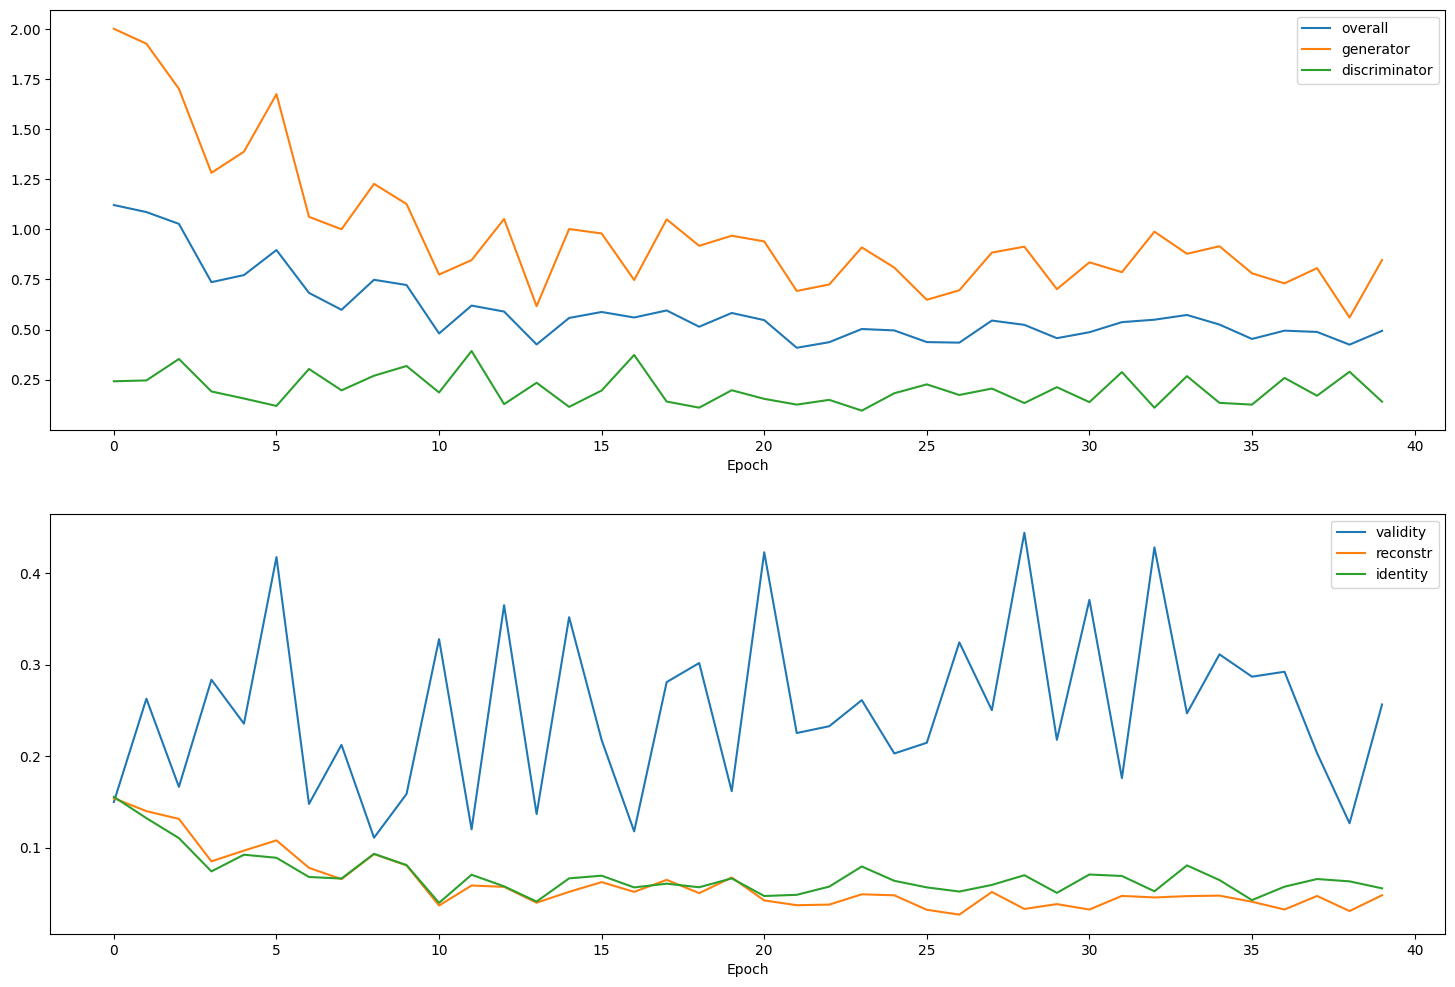

In [ ]:
# LOSS PLOT
save_folder = './loss_plots/'
plot_name = f'loss.png'
file_path = os.path.join(save_folder, plot_name)


fig, axes = plt.subplots(ncols=1, nrows=2, figsize=(18, 12), facecolor='w')
epoch_num = len(model.losses)

axes[0].plot(np.arange(epoch_num), model.losses, label='overall')
axes[0].plot(np.arange(epoch_num), model.G_mean_losses, label='generator')
axes[0].plot(np.arange(epoch_num), model.D_mean_losses, label='discriminator')
axes[0].legend()
axes[0].set_xlabel('Epoch')

axes[1].plot(np.arange(epoch_num), model.validity, label='validity')
axes[1].plot(np.arange(epoch_num), model.reconstr, label='reconstr')
axes[1].plot(np.arange(epoch_num), model.identity, label='identity')
axes[1].legend()
axes[1].set_xlabel('Epoch')

plt.show()

## **SUBMIT** 🤩🎉 (IF COLAB DOESN'T KICK YOU OUT 😞)

---



In [ ]:
def submit(model, transform):
    os.makedirs('./results', exist_ok=True)
    net = model.G_basestyle

    net.eval()
    photo_img_paths = glob.glob('../Some_Datasets/landscape_resized_256/*.jpg')

    for path in photo_img_paths:
        photo_id = path.split('/')[-1]
        img = transform(Image.open(path), phase='test')

        gen_img = net(img.unsqueeze(0))[0]

        # Reverse Normalization
        gen_img = gen_img * 0.5 + 0.5
        gen_img = gen_img * 255
        gen_img = gen_img.detach().numpy().astype(np.uint8)

        gen_img = np.transpose(gen_img, [1,2,0])

        gen_img = Image.fromarray(gen_img)
        gen_img.save(os.path.join('./results/', photo_id))

    # Make Zipfile
    shutil.make_archive("./results", 'zip', "./results/")

    # Delete Origin file
    shutil.rmtree('./reults')

In [ ]:
submit(model, transform)

NameError: ignored